In this exercise, we want to build an denoising autoencoder. Given a picture of a circle with some noise, we want to reconstruct the clean image with a neural network.

# Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow.keras as K

# Create input images

We use black and white images of width and height 64 pixel.
We want to place circles with random radius in a random position.

In [2]:
N_width = 64

circle_rmin = 3
circle_rmax = int(N_width/2)

circle_posmin = 0
circle_posmax = N_width

We use the `numpy` notation to avoid slow for loops (particularly useful for operations with larger arrays)

In [3]:
def get_batch(N_batch):
#     Given the number of samples to create,
#     we extract randomly the radius of each circle
#     and its position in the image.

#     We use this shape: [N_batches, N_width, N_width, channels]
#     A black and white image has only a single channel
    sizes = np.random.randint(circle_rmin,circle_rmax, size = [N_batch, 1, 1])
    
#     We want to select all the pixels that are close to the center of the circle
#     up to a distance sizes. The center has two coordinates (x,y)
    centers = np.random.randint(circle_posmin,circle_posmax, size = [N_batch,1,1,2])

#     We create an auxiliary array with the indices.
    indices_x, indices_y = np.meshgrid(
        np.arange(N_width),
        np.arange(N_width)
    )
    
    indices = np.concatenate([
        indices_x.reshape([1, N_width ,N_width,1]),
        indices_y.reshape([1, N_width ,N_width,1])],
        axis=-1)
    
    return np.sqrt(np.sum((indices-centers)**2,axis=-1)) < sizes

In [4]:
test_batches = get_batch(10)

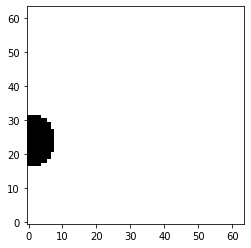

In [5]:
plt.imshow(test_batches[0,:,:], cmap="binary", origin="lower")
plt.show()

In [6]:
noise_prob = 0.8
noise_delta = 1

def put_noise(original_batch):
    N_batch = len(original_batch)
    val_noise = np.random.uniform(low=-noise_delta, high=noise_delta, size=[N_batch,N_width,N_width])
    bool_noise = np.random.uniform(low=0, high=1, size=[N_batch,N_width,N_width])

    new_batch = original_batch.astype(float)
    new_batch[bool_noise<noise_prob] = np.maximum(np.minimum(
        new_batch[bool_noise<noise_prob] + val_noise[bool_noise<noise_prob]
        ,1),0)
    return new_batch

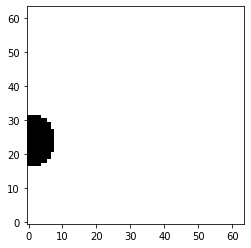

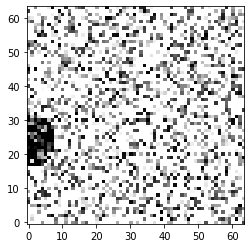

In [7]:
test_noisybatches = put_noise(test_batches)

plt.imshow(test_batches[0,:,:], cmap="binary", origin="lower")
plt.show()

plt.imshow(test_noisybatches[0,:,:], cmap="binary", origin="lower")
plt.show()

In [8]:
def create_net():
    my_kernel = [10,10]
    my_pool = 4
    N_filters = 5
    
    net = K.Sequential()
    
    net.add(K.layers.Conv2D(
        input_shape = (N_width, N_width, 1),
        filters = N_filters, 
        kernel_size = my_kernel,
        activation = "relu", 
        padding = "same"))
    
    net.add(K.layers.AveragePooling2D(pool_size=my_pool))
    
    net.add(K.layers.Conv2D(
        filters = N_filters, 
        kernel_size = my_kernel,
        activation = "relu", 
        padding = "same"))
  
    net.add(K.layers.AveragePooling2D(pool_size=my_pool))
    
    net.add(K.layers.Conv2D(
        filters = N_filters, 
        kernel_size = my_kernel,
        activation = "relu", 
        padding = "same"))
    
    net.add(K.layers.UpSampling2D(size=my_pool))
    
    net.add(K.layers.Conv2D(
        filters = N_filters, 
        kernel_size = my_kernel,
        activation = "relu", 
        padding = "same"))
    
    net.add(K.layers.UpSampling2D(size=my_pool))
    
    net.add(K.layers.Conv2D(
        filters = 1, 
        kernel_size = my_kernel,
        activation = "relu", 
        padding = "same"))
    
    net.compile(
        loss="mean_squared_error",
        optimizer="adam")
    
    net.summary()
    return net

In [9]:
net = create_net()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 5)         505       
_________________________________________________________________
average_pooling2d (AveragePo (None, 16, 16, 5)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 5)         2505      
_________________________________________________________________
average_pooling2d_1 (Average (None, 4, 4, 5)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 5)           2505      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 16, 16, 5)         0         
______________________

In [10]:
costs = []
N_batches = 500
N_epochs =  1000

In [ ]:
for i in range(N_epochs):
    train_in = get_batch(N_batches)
    train_out = put_noise(train_in)
    
    costs.append(net.train_on_batch(
        train_in.reshape([-1,N_width, N_width,1]),
        train_out.reshape([-1,N_width, N_width,1]))
                )
    
    print("Training: %d/%d,\tCost = %2.7f" 
          % (i+1,N_epochs,np.array(costs)[-1]))

Instructions for updating:
Use tf.cast instead.


In [ ]:
plt.figure(figsize=[15,5])
plt.plot(np.array(costs))
plt.title("Cost function")
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")

In [ ]:
test_pic = get_batch(1)
noisy_pic = put_noise(test_pic)
net_out = net.predict_on_batch(noisy_pic.reshape([-1,N_width, N_width,1])).reshape([-1,N_width, N_width])

plt.figure(figsize=[15,5])
plt.subplot(1,3,1)
plt.imshow(test_pic[0,:,:], cmap="binary", origin="lower")
plt.title("Original")
plt.xlabel("x")
plt.ylabel("y")

plt.subplot(1,3,2)
plt.imshow(noisy_pic[0,:,:], cmap="binary", origin="lower")
plt.title("Noisy image")
plt.xlabel("x")
plt.ylabel("y")

plt.subplot(1,3,3)
plt.imshow(net_out[0,:,:], cmap="binary", origin="lower")
plt.title("Net output")
plt.xlabel("x")
plt.ylabel("y")


plt.show()